In [1]:
from multiprocessing import Pool
import numpy as np
from graph import Circle, Grid, RandomRegular, GraphByDegrees, ErdosRenyi, ScaleFree, SmallWorld
from viz import draw_data
from utils import Timer, partition
from engine import fun
from engine_mono import fun_mono
from engine_sum import fun_sum
from engine_tot import fun_tot
from graph_toolset import coreness, degs
import jupyternotify
import random
import matplotlib.cm as cm
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

# from scipy.misc import imresize
"""
import matplotlib as mpl
import matplotlib.font_manager as font_manager

mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
"""
import matplotlib.pyplot as plt


from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

import pickle

%matplotlib notebook

<IPython.core.display.Javascript object>

In [2]:
def total(graph, keys):
    res = dict()
    if 'rho' in keys:
        res['rho'] = graph.V
    if 'l' in keys:
        res['l'] = graph.V
    return res

In [3]:
def addr(filename):
    return '/home/zhuk1996/data/' + filename + '.pkl'

In [4]:
def calc(fun_name, alphas, bs, graphs, T, out_file, init_type='01', keys=['rho', 'l'], set_builder=total, pool_size=32):
    pool = Pool(pool_size)
    
    res = dict()
    for key in keys:
        res[key] = []

    timer = Timer()
    
    now = 0
    
    for graph in graphs:
        local_timer = Timer()
        
        sets = set_builder(graph, keys)
        
        points = [(graph, b, alpha, T, init_type, sets) for alpha in alphas for b in bs]
        
        if fun_name == 'fun':
            cur = pool.map(fun, points)
        elif fun_name == 'mono':
            cur = pool.map(fun_mono, points)
        elif fun_name == 'sum':
            cur = pool.map(fun_sum, points)
        elif fun_name == 'tot':
            cur = pool.map(fun_tot, points)
        else:
            raise Exception(f'dont know fun name {fun_name}!')
        
        for key in keys:
            tmp = []
            for step in cur:
                tmp.append(step[key])
            
            tmp = np.array(tmp)
            tmp = np.reshape(tmp, (len(alphas), len(bs), tmp.shape[1]))
            res[key].append(tmp)
        
        t = local_timer.measure()
        now += 1
        rem = len(graphs) - now
        print(f'#{now} passed in {local_timer.measure()},  projected end in {timer.measure() / now * rem / 60} minutes', flush=True)
        
    for key in keys:
        res[key] = np.array(res[key])
        
    timer.print_elapsed()
    
    with open(addr(out_file), 'wb') as f:
        pickle.dump(res, f)
    
    print(f'Written to {addr(out_file)}')
    

In [5]:
def cut_alpha(data, alpha_id):
    res = dict()
    for key, arr in data.items():
        res[key] = arr[:, alpha_id, :, :]
    return res

In [6]:
def plot_means(bs, data, last, keys, title, show_data=False):
    fig, ax = plt.subplots()
    
    for key in keys:
        cur = np.apply_along_axis(np.mean, 2, data[key][:, :, -last:])
        if show_data:
            for t in cur:
                ax.scatter(bs, t, s=1, alpha=.5)

        cur = np.apply_along_axis(np.mean, 0, cur)
        # cur = np.apply_along_axis(np.median, 0, cur)
        ax.plot(bs, cur, '-', label=f'{key}')
    # ax.legend()
    ax.set_title(title)
    plt.show()

In [7]:
def single(bs, filename, last, keys, name, show_data=True):
    fig, ax = plt.subplots()#figsize=(3 * 3, 2.5 * 2))
    plt.locator_params(axis='y', nbins=5)
    plt.locator_params(axis='x', nbins=10)
    
    with open(addr(filename), 'rb') as f:
        data = cut_alpha(pickle.load(f), 0)

        
        for key in keys:
            if key.startswith('std'):
                cur = np.apply_along_axis(np.std, 2, data[key[3:]][:, :, -last:])
            else:
                cur = np.apply_along_axis(np.mean, 2, data[key][:, :, -last:])
            if show_data:
                for t in cur:
                    ax.scatter(bs, t, s=1, alpha=.5, c='red')

            cur = np.apply_along_axis(np.mean, 0, cur)
            # cur = np.apply_along_axis(np.median, 0, cur)
            ax.plot(bs, cur, '-', label=f'{key}')
        ax.set_xlabel(r'$b$')
        ax.set_ylabel(r'$\rho$')
        ax.set_title(name)

    plt.show()

In [8]:
def plot_2d(bs, filenames, last, keys, names, show_data=True):
    fig, grid = plt.subplots(nrows=2, ncols=3, figsize=(3 * 3, 2.5 * 2), sharex=True, sharey=True)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.2)
    plt.locator_params(axis='y', nbins=5)
    plt.locator_params(axis='x', nbins=10)
    
    for name, filename, s in zip(names, filenames, range(len(names))):
        with open(addr(filename), 'rb') as f:
            data = cut_alpha(pickle.load(f), 0)
        
        i = s // 3
        j = s % 3
        
        ax = grid[i][j]
        
        for key in keys:
            if key.startswith('std'):
                cur = np.apply_along_axis(np.std, 2, data[key[3:]][:, :, -last:])
            else:
                cur = np.apply_along_axis(np.mean, 2, data[key][:, :, -last:])
            if show_data:
                for t in cur:
                    ax.scatter(bs, t, s=1, alpha=.5, c='red')

            cur = np.apply_along_axis(np.mean, 0, cur)
            # cur = np.apply_along_axis(np.median, 0, cur)
            ax.plot(bs, cur, '-', label=f'{key}')
        # ax.legend()
        if j == 0:
            ax.set_ylabel(r'$\rho$')
        if i == 1:
            ax.set_xlabel(r'$b$')
        ax.set_title(name)

    plt.show()

<IPython.core.display.Javascript object>


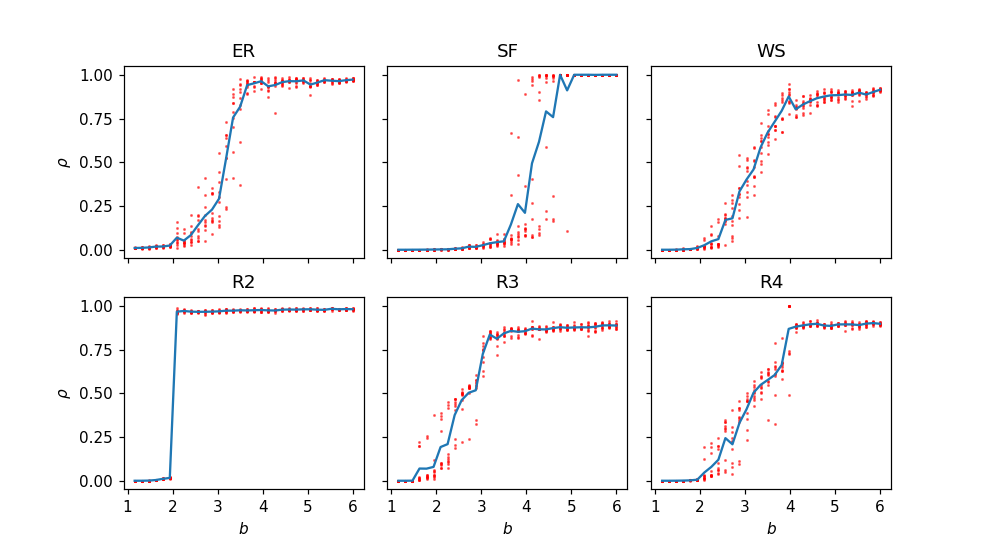

In [35]:
plot_of_prefix('bmono', 100)

<IPython.core.display.Javascript object>


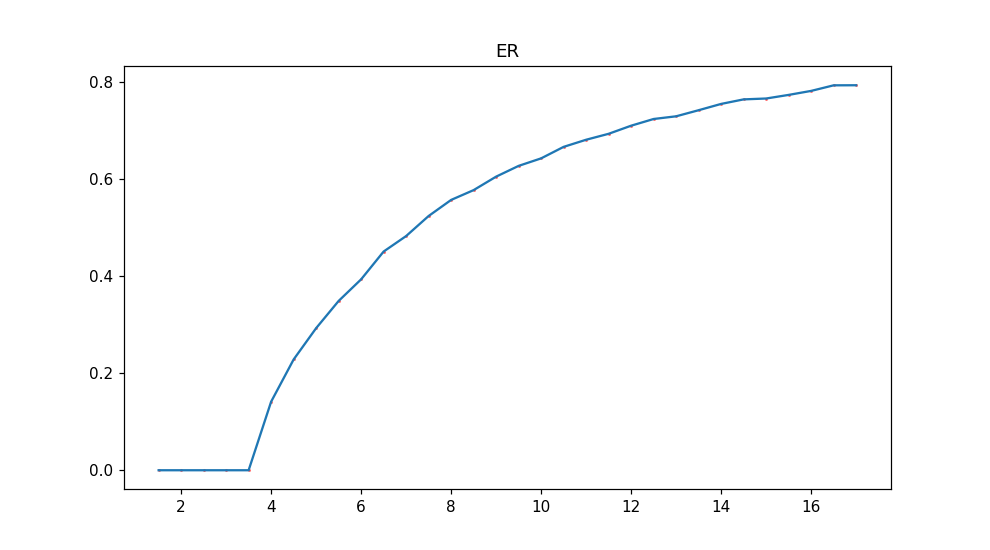

In [13]:
single(bs, 'btot_er', 1000, ['rho'], 'ER')

In [11]:
calc('tot', alphas, bs, er_graphs[:1], 10000, 'btot_er')

#1 passed in 293.1235988140106,  projected end in 0.0 minutes
time elapsed = 293.1308641433716
Written to /home/zhuk1996/data/btot_er.pkl


In [26]:
plot_2d(bs, names, 100, ['rho'], ['ER', 'SF', 'WS', 'R2', 'R3', 'R4'])

NameError: name 'names' is not defined

In [9]:
def run_and_draw(prefix, fun, cnt, steps, draw):
    timer = Timer()
    names = [prefix + suffix for suffix in ['_er', '_sf', '_ws', '_two', '_three', '_four']]
    for name, graphs in zip(names, 
                            [er_graphs, sf_graphs, ws_graphs, two_graphs, three_graphs, four_graphs]):
        calc(fun, alphas, bs, graphs[:cnt], steps, name)
    print(f'overall time = {timer.measure() / 60} mins')
    # plot_2d(bs, names, draw, ['rho'], ['ER', 'SF', 'WS', 'R2', 'R3', 'R4'])

In [10]:
def plot_of_prefix(prefix, draw):
    names = [prefix + suffix for suffix in ['_er', '_sf', '_ws', '_two', '_three', '_four']]
    plot_2d(bs, names, draw, ['rho'], ['ER', 'SF', 'WS', 'R2', 'R3', 'R4'])

In [11]:
def print_info(filename):
    with open(addr(filename), 'rb') as f:
            data = pickle.load(f)
            print(data['rho'].shape)

In [9]:
print_info('sum_er')

(20, 32, 32, 600)


In [12]:
bs = partition(1, 10, 32)
alphas = [.1]
n = 1000
cnt = 10
print(bs)
print(alphas)

[ 1.28125  1.5625   1.84375  2.125    2.40625  2.6875   2.96875  3.25
  3.53125  3.8125   4.09375  4.375    4.65625  4.9375   5.21875  5.5
  5.78125  6.0625   6.34375  6.625    6.90625  7.1875   7.46875  7.75
  8.03125  8.3125   8.59375  8.875    9.15625  9.4375   9.71875 10.     ]
[0.1]


In [13]:
def ER(t):
    return ErdosRenyi(*t)

def SF(t):
    return ScaleFree(*t)

def WS(t):
    return SmallWorld(*t)

er_graphs = Pool(32).map(ER, [(n, 4. / n)] * cnt)
sf_graphs = Pool(32).map(SF, [(n, 4)] * cnt)
ws_graphs = Pool(32).map(WS, [(n, 4, .5)] * cnt)
four_graphs = Pool(32).map(GraphByDegrees, [{4: n}] * cnt)
two_graphs = Pool(32).map(GraphByDegrees, [{2: n}] * cnt)
three_graphs = Pool(32).map(GraphByDegrees, [{3: n}] * cnt)

In [19]:
calc('tot', alphas, bs, er_graphs[:1], 10000, 'er_tot')

#1 passed in 325.92647099494934,  projected end in 0.0 minutes
time elapsed = 325.93264746665955
Written to /home/zhuk1996/data/er_tot.pkl


<IPython.core.display.Javascript object>


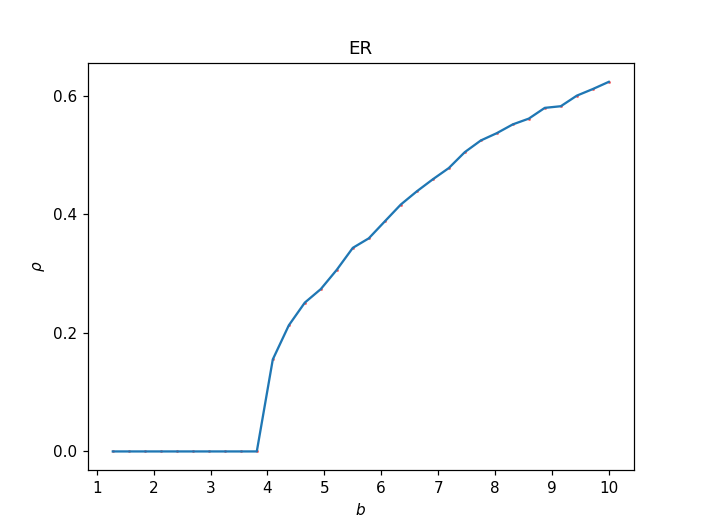

In [21]:
single(bs, 'er_tot', 1000, ['rho'], 'ER')

In [22]:
calc('tot', alphas, bs, sf_graphs[:1], 10000, 'sf_tot')

#1 passed in 517.2135462760925,  projected end in 0.0 minutes
time elapsed = 517.220201253891
Written to /home/zhuk1996/data/sf_tot.pkl


<IPython.core.display.Javascript object>


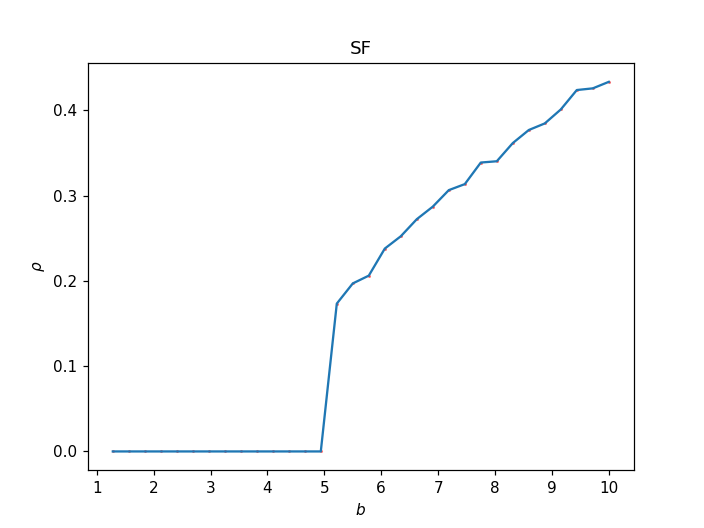

In [23]:
single(bs, 'sf_tot', 1000, ['rho'], 'SF')

In [24]:
calc('tot', alphas, bs, ws_graphs[:1], 10000, 'ws_tot')

#1 passed in 309.5720295906067,  projected end in 0.0 minutes
time elapsed = 309.57919120788574
Written to /home/zhuk1996/data/ws_tot.pkl


<IPython.core.display.Javascript object>


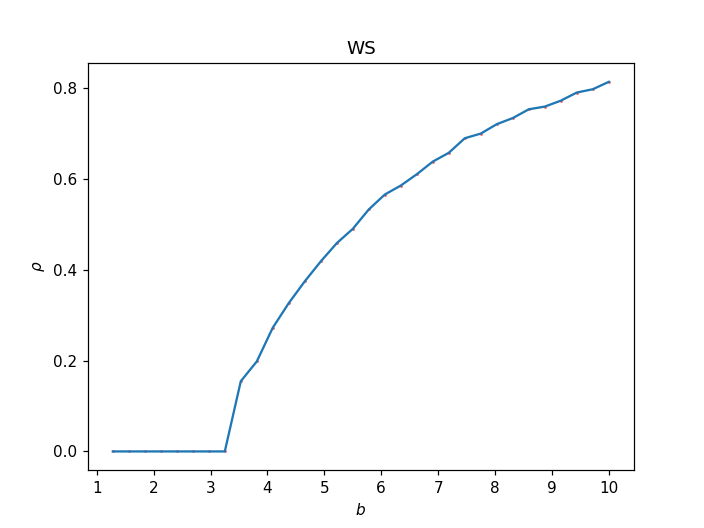

In [25]:
single(bs, 'ws_tot', 1000, ['rho'], 'WS')

In [26]:
calc('tot', alphas, bs, two_graphs[:1], 10000, 'two_tot')

#1 passed in 177.63895463943481,  projected end in 0.0 minutes
time elapsed = 177.645201921463
Written to /home/zhuk1996/data/two_tot.pkl


<IPython.core.display.Javascript object>


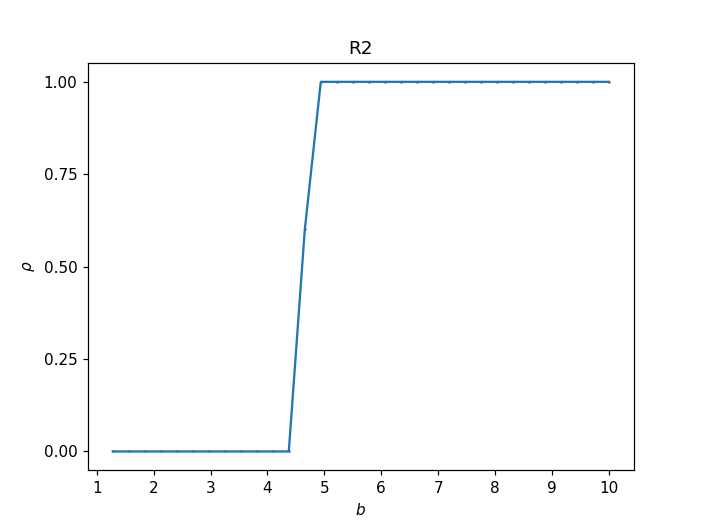

In [27]:
single(bs, 'two_tot', 1000, ['rho'], 'R2')

In [28]:
calc('tot', alphas, bs, three_graphs[:1], 10000, 'three_tot')

#1 passed in 230.28428602218628,  projected end in 0.0 minutes
time elapsed = 230.29222774505615
Written to /home/zhuk1996/data/three_tot.pkl


<IPython.core.display.Javascript object>


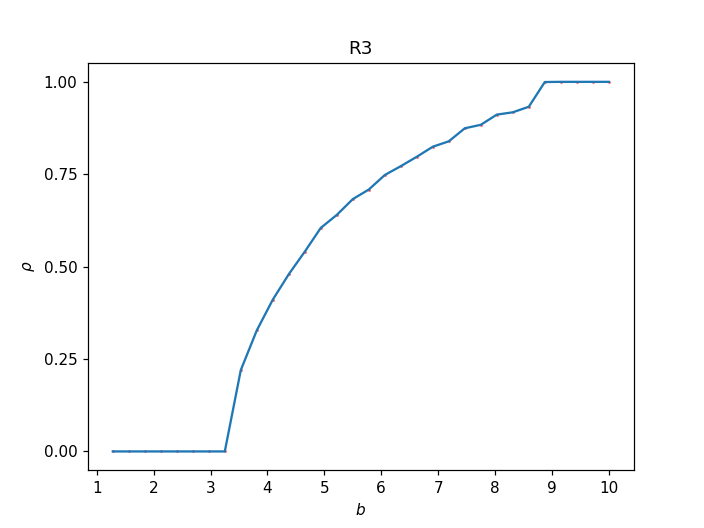

In [29]:
single(bs, 'three_tot', 1000, ['rho'], 'R3')

In [30]:
calc('tot', alphas, bs, four_graphs[:1], 10000, 'four_tot')

#1 passed in 277.5105679035187,  projected end in 0.0 minutes
time elapsed = 277.5159902572632
Written to /home/zhuk1996/data/four_tot.pkl


<IPython.core.display.Javascript object>


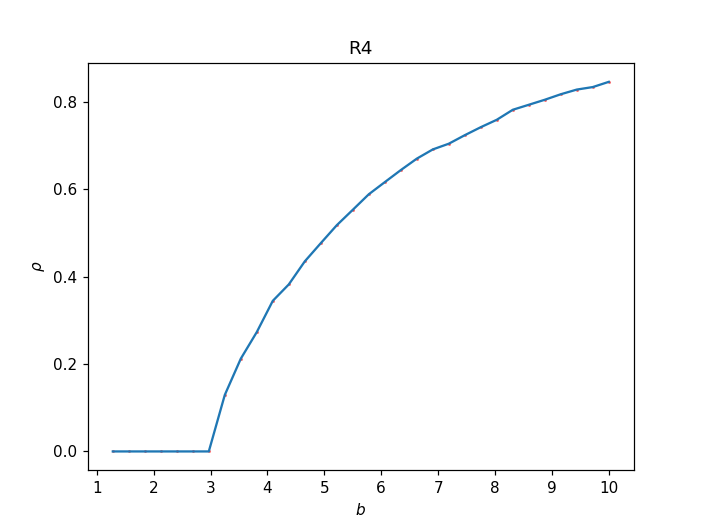

In [31]:
single(bs, 'four_tot', 1000, ['rho'], 'R4')

<IPython.core.display.Javascript object>


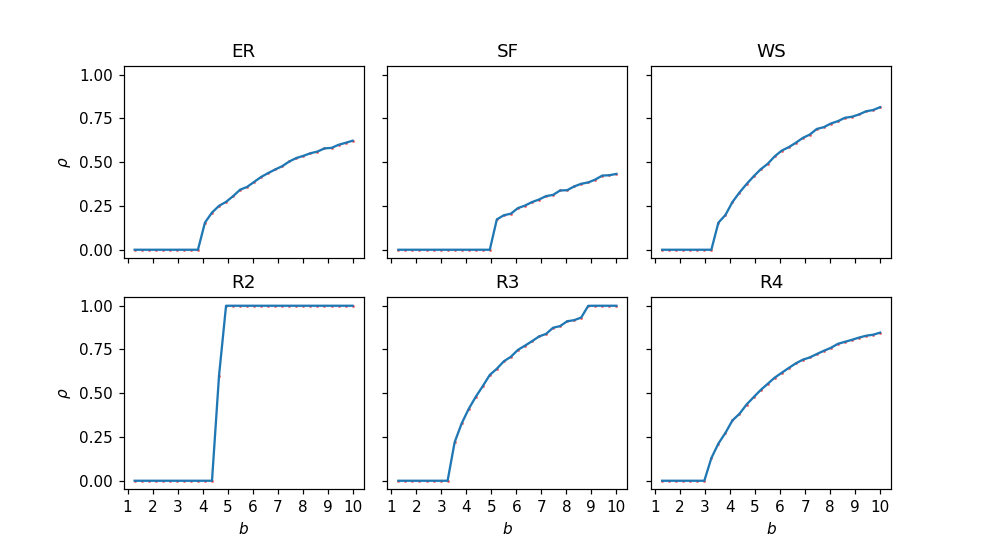

In [32]:
plot_2d(bs, ['er_tot', 'sf_tot', 'ws_tot', 'two_tot', 'three_tot', 'four_tot'], 1000, ['rho'], ['ER', 'SF', 'WS', 'R2', 'R3', 'R4'])

In [41]:
run_and_draw('bsum', 'sum', 10, 200, 10)

#1 passed in 12.76321816444397,  projected end in 1.9144880890846252 minutes
#2 passed in 12.48844861984253,  projected end in 1.683643674850464 minutes
#3 passed in 12.470771074295044,  projected end in 1.4671287059783935 minutes
#4 passed in 12.859333992004395,  projected end in 1.2646579682826995 minutes
#5 passed in 12.439636945724487,  projected end in 1.0504467010498046 minutes
#6 passed in 12.28931713104248,  projected end in 0.8368537690904405 minutes
#7 passed in 12.458532094955444,  projected end in 0.6269717182431902 minutes
#8 passed in 12.455936193466187,  projected end in 0.41763749420642854 minutes
#9 passed in 12.92814588546753,  projected end in 0.20955905075426454 minutes
#10 passed in 12.635126829147339,  projected end in 0.0 minutes
time elapsed = 125.80237984657288
Written to /home/zhuk1996/data/bsum_er.pkl
#1 passed in 16.015264749526978,  projected end in 2.4022961497306823 minutes
#2 passed in 15.93751072883606,  projected end in 2.130499998728434 minutes
#3 pas

<IPython.core.display.Javascript object>


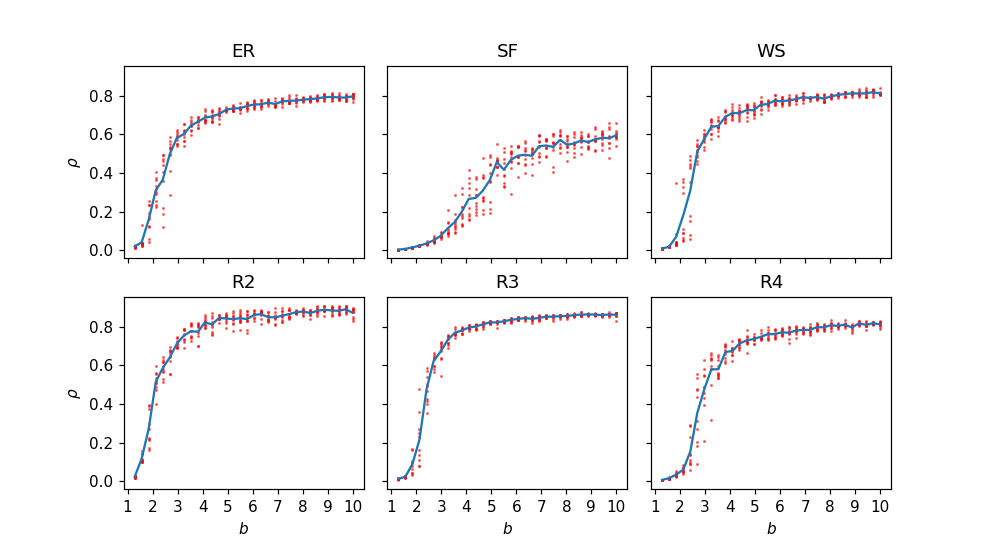

In [42]:
plot_of_prefix('bsum', 20)

In [14]:
run_and_draw('bfun', 'fun', 10, 10000, 10)

#1 passed in 179.62851119041443,  projected end in 26.944285297393797 minutes
#2 passed in 177.60221195220947,  projected end in 23.816724650065105 minutes
#3 passed in 184.050607919693,  projected end in 21.05066402488285 minutes
#4 passed in 176.11080408096313,  projected end in 17.935421818494795 minutes
#5 passed in 184.59650945663452,  projected end in 15.033576806386312 minutes
#6 passed in 181.44246888160706,  projected end in 12.038426656193202 minutes
#7 passed in 174.70459365844727,  projected end in 8.986888345650264 minutes
#8 passed in 182.91312980651855,  projected end in 6.004495400190353 minutes
#9 passed in 174.78233528137207,  projected end in 2.992337846314465 minutes
#10 passed in 178.37281441688538,  projected end in 0.0 minutes
time elapsed = 1794.3721647262573
Written to /home/zhuk1996/data/bfun_er.pkl
#1 passed in 277.525506734848,  projected end in 41.62883448600769 minutes
#2 passed in 277.19677662849426,  projected end in 36.98226269086202 minutes
#3 passed i

<IPython.core.display.Javascript object>


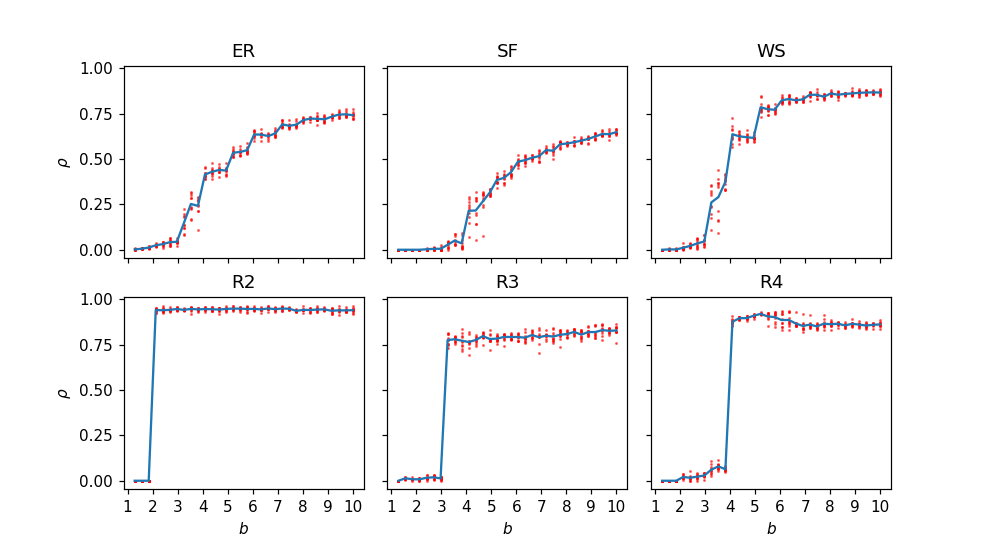

In [15]:
plot_of_prefix('bfun', 100)